In [523]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import plotly
import plotly.express as px

In [524]:

def read_log(f):
    with open(f, "r") as handle:
        res = handle.readlines()
    res = [ r.split(" ") for r in res]
    res = [ [ r2.rstrip().lstrip()  for r2 in r1 if len(r2) > 0 ] for r1 in res]
    df = pd.DataFrame(res)
    df.columns = ["Epoch", "Step", "Loss1", "NER Loss", "F Score", "Precision", "Recall", "Score"]
    return df

In [552]:
models_log = pd.read_csv("logs/models.csv")

models_log = models_log.iloc[:5]

In [553]:
df = read_log(f"logs/{m['model']}.log")


In [554]:
dfs = []
for m in models_log.to_dict("records"):
    df = read_log(f"logs/{m['model']}.log")
    df["trainable_params (Millions)"] = m["trainable_params"] / 1000000
    df["Model Name"] = m["model"]
    dfs.append(df)

df = pd.concat(dfs)
df["NER Loss"] = df["NER Loss"].astype(float)
df["Step"] = df["Step"].astype(int)
df = df.loc[df.Step > 500]
df["Score"] = df.Score.astype(float)
#df = df.loc[df["Step"] != "0"]

In [555]:
def proc_x(x):
    params = str(x["trainable_params (Millions)"])[:4]
    name = x["Model Name"]
    if "roberta" in name:
        val = name[len("roberta"):]
        name = "roberta"
    else:
        val = name[len("bert"):]
        name = "bert"
    return f"Model: {name} | Layers to train: {val}"
    
df["Description"] = df.apply(proc_x, axis=1)

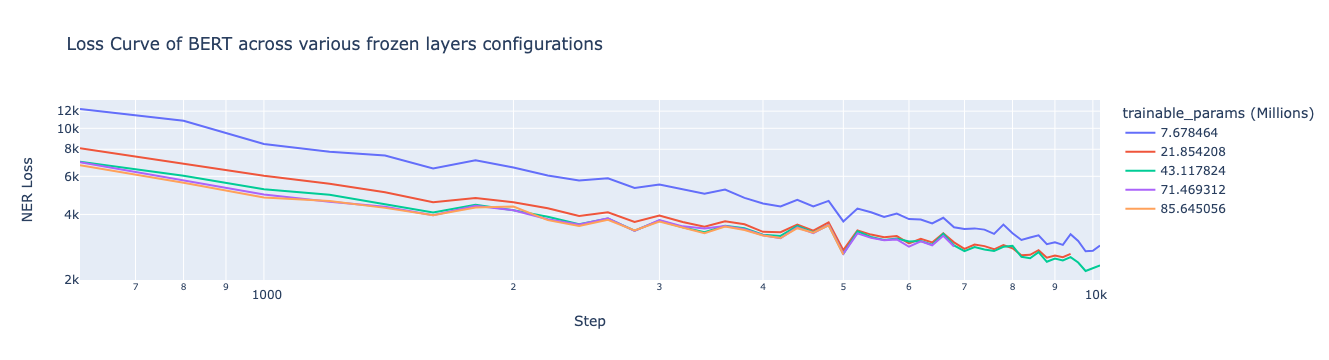

In [556]:
px.line(df, x="Step", y="NER Loss", color="trainable_params (Millions)", log_y=True, log_x=True, title="Loss Curve of BERT across various frozen layers configurations")

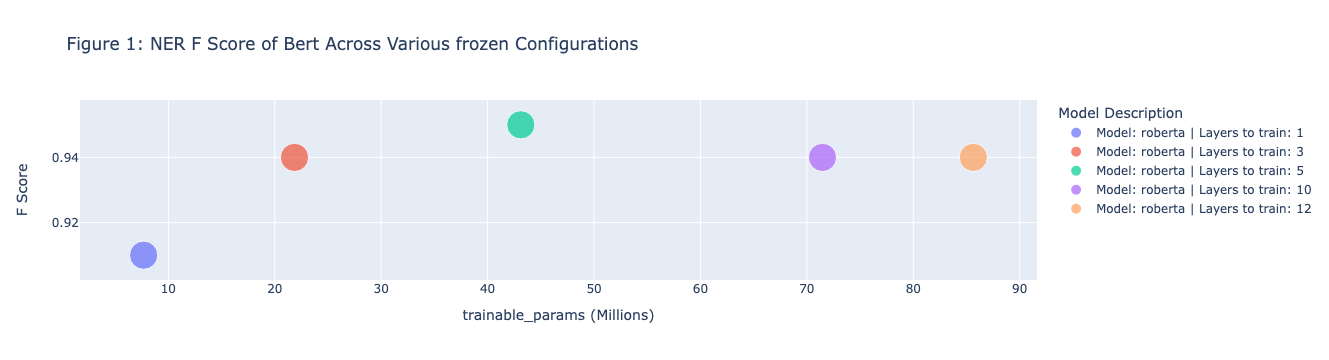

In [557]:

resdf = df.groupby("trainable_params (Millions)").agg({"Score": ["max"], "Description": "first"})

resdf["trainable_params (Millions)"] = resdf.index
resdf["F Score"] = resdf[("Score", "max")]
resdf["Model Description"] = resdf[("Description", "first")]

resdf["size"] = 1

px.scatter(resdf, x="trainable_params (Millions)", y="F Score", title="Figure 1: NER F Score of Bert Across Various frozen Configurations", color="Model Description", size="size")

In [531]:
resdf

,Score,Description,trainable_params (Millions),F Score,Model Description,size
,max,first,,,,
trainable_params (Millions),,,,,,
7.678464,0.86,Model: bert | Layers to train: 1,7.678464,0.86,Model: bert | Layers to train: 1,1
21.854208,0.89,Model: bert | Layers to train: 3,21.854208,0.89,Model: bert | Layers to train: 3,1
50.205696,0.92,Model: bert | Layers to train: 5,50.205696,0.92,Model: bert | Layers to train: 5,1
64.381440,0.93,Model: bert | Layers to train: 10,64.381440,0.93,Model: bert | Layers to train: 10,1
85.645056,0.93,Model: bert | Layers to train: full,85.645056,0.93,Model: bert | Layers to train: full,1


In [532]:
res = pd.read_csv("results/model_results.csv").to_dict("records")

import json
perf = []
for r in res:
    with open(f"results/{r['ModelName']}.json", 'r') as handle:
        meta = json.load(handle)

        p = meta["performance"]
        entp = p["ents_per_type"]

        results = dict(
            model=r["ModelName"],
            TotalParameters=r["TotalParameters"],
            Global_F_Score=p["ents_f"],
            Precision=p["ents_p"],
            Recall=p["ents_r"],
            Patient=entp["PATIENT"]["f"],
            Date=entp["DATE"]["f"],
            Doctor=entp["DOCTOR"]["f"],
            Age=entp["AGE"]["f"],
            Hospital=entp["HOSPITAL"]["f"]
        )
        perf.append(results)

df = pd.DataFrame(perf)
df.columns

tmps = []
for row in df.to_dict("records"):
    model = row["model"]
    params = row["TotalParameters"]
    tmp = [ dict(model=model, n_params=params, Entity=name, F_Score=row[name]) for name in df.columns[2:] ] 
    tmps.extend(tmp)

df = pd.DataFrame(tmps)
df["is_pretrained"] = df.model.apply(lambda x: x in ["clinical_bert", "bert_base_NER", "scibert", "pubmed_bert", ])

df = df.sort_values(by=["Entity", "F_Score"])

In [533]:
pd.DataFrame(perf).to_csv("model_results.csv")

In [534]:
pd.DataFrame(perf)

,model,TotalParameters,Global_F_Score,Precision,Recall,Patient,Date,Doctor,Age,Hospital
0,multihash,10000,0.781243,0.812051,0.752687,0.816074,0.832363,0.839035,0.907048,0.700794
1,bert_base_NER,340000000,0.839361,0.855660,0.823672,0.800000,0.932674,0.849401,0.871308,0.677502
2,bert_base_uncased,340000000,0.928061,0.932600,0.923566,0.946754,0.968833,0.942553,0.968907,0.868670
3,bert_mini,11201594,0.749371,0.779650,0.721356,0.693847,0.879827,0.742035,0.788288,0.595238
4,bert_small,28795194,0.812919,0.828307,0.798093,0.785714,0.912173,0.850995,0.834547,0.641509
5,bert_tiny,4416698,0.607382,0.651195,0.569093,0.539683,0.756883,0.594082,0.701754,0.441797
6,clinical_bert,108340804,0.814815,0.829310,0.800817,0.712271,0.921613,0.818078,0.924319,0.706630
7,roberta,125000000,0.941957,0.938279,0.945664,0.964912,0.977073,0.945125,0.976096,0.880573
8,scibert,340000000,0.856254,0.880781,0.833056,0.827195,0.943287,0.889135,0.922917,0.729636
9,pubmed_bert,340000000,0.857885,0.866698,0.849251,0.822523,0.943462,0.889010,0.878286,0.786624


In [535]:
size_df = df.loc[df.model.apply(lambda x: x in ["multihash", "bert_mini", "bert_small", "bert_tiny", "roberta", "bert_base_uncased"])]
pretrain_df = df.loc[df.model.apply(lambda x: x in ["bert_base_NER", "bert_base_uncased", "clinical_bert", "scibert", "pubmed_bert", "roberta"])]


<ipython-input-537-8286c4227031>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



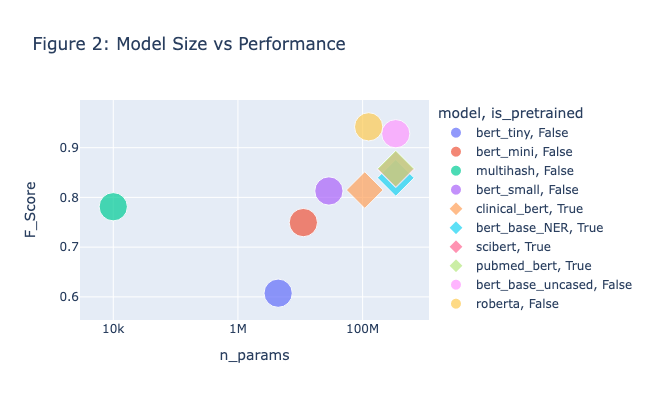

In [537]:
tmp = df.loc[df.Entity.apply(lambda x: x in ["Global_F_Score"])]
tmp["scaled_n_params"] = tmp.n_params.apply(lambda x: .3)
px.scatter(tmp.sort_values("F_Score"), x="n_params", y="F_Score",  log_x=True, color="model", symbol="is_pretrained", size="scaled_n_params", title="Figure 2: Model Size vs Performance", height=400)

<ipython-input-550-5315d304a11f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



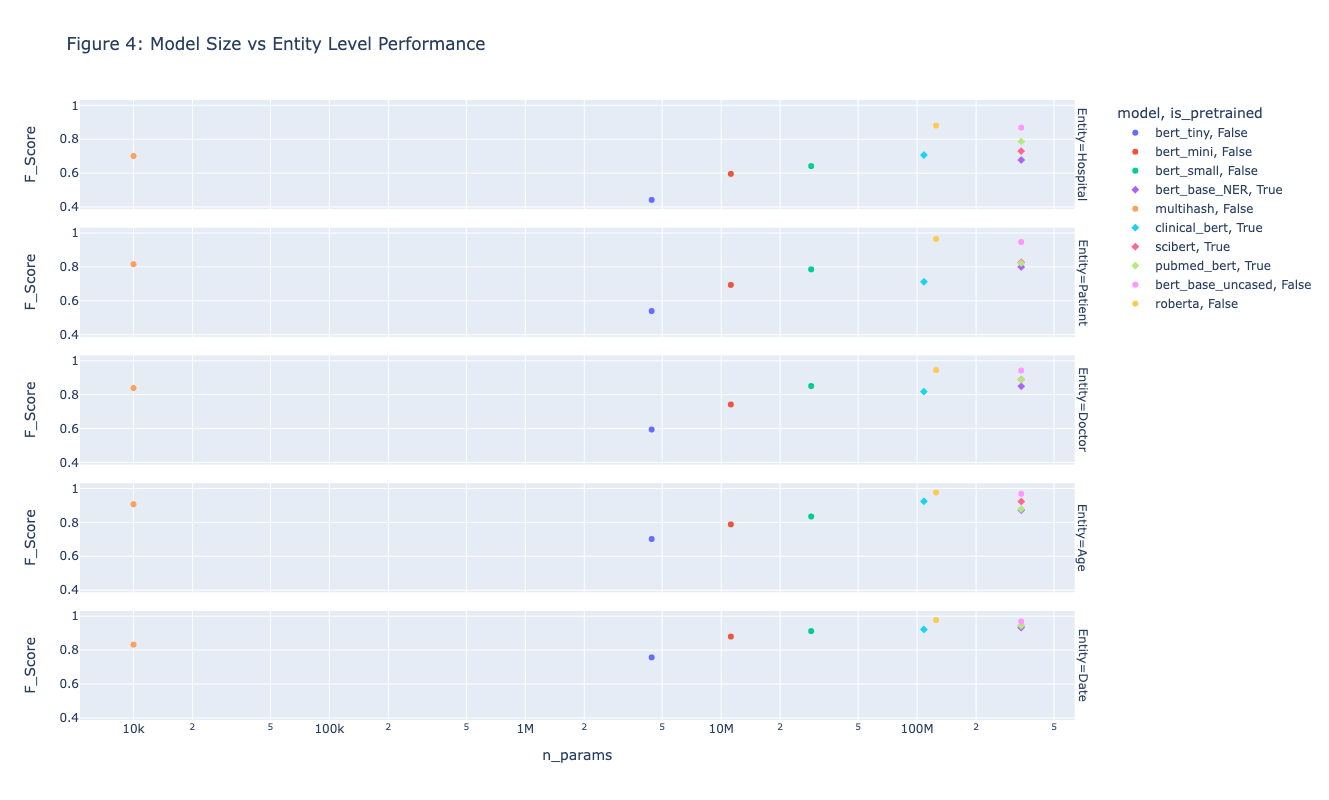

In [550]:
tmp = df.loc[df.Entity.apply(lambda x: x in ["Date", "Age", "Doctor", "Hospital", "Patient"])]
tmp["scaled_n_params"] = tmp.n_params.apply(lambda x: .3)
px.scatter(tmp.sort_values("F_Score"), x="n_params", y="F_Score",  log_x=True, color="model", facet_row="Entity",
           symbol="is_pretrained",  title="Figure 4: Model Size vs Entity Level Performance", height=800, width=500)

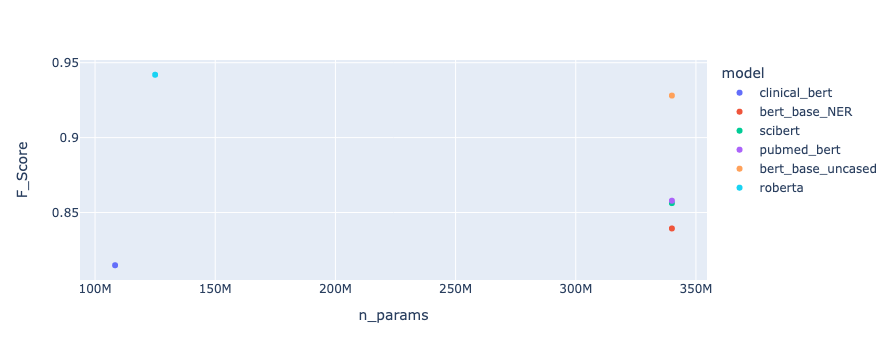

In [507]:
tmp = df.loc[df.Entity.apply(lambda x: x in ["Global_F_Score", ])]
#tmp = df.loc[df.Entity.apply(lambda x: x in ["Date", "Age", "Doctor", "Hospital", "Patient"])]
tmp = tmp.loc[tmp.model.apply(lambda x: x in ["bert_base_NER", "bert_base_uncased", "clinical_bert", "scibert", "pubmed_bert", "roberta"])]
px.scatter(tmp, x="n_params", y="F_Score",  color="model" )

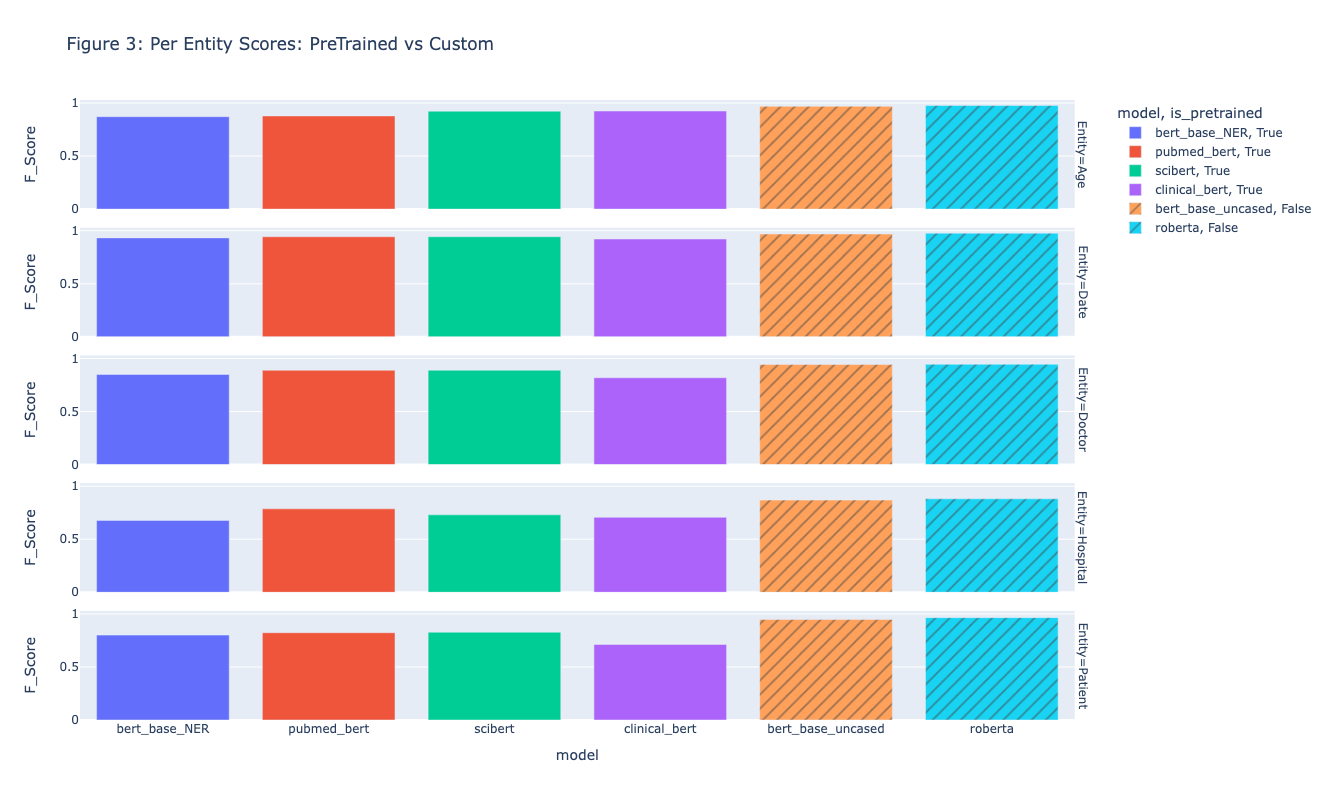

In [551]:
tmp = pretrain_df.loc[pretrain_df.Entity.apply(lambda x: x in ["Date", "Age", "Doctor", "Hospital", "Patient"])]
px.bar(tmp, x="model", y="F_Score",  color="model", height=800, width=500, facet_row="Entity", title="Figure 3: Per Entity Scores: PreTrained vs Custom", pattern_shape="is_pretrained", )

In [476]:
tmp = pretrained_df.loc[size_df.Entity.apply(lambda x: x in ["Date", "Age", "Doctor", "Hospital", "Patient"])]
px.bar(tmp, x="model", y="F_Score",  color="model", facet_col="Entity",)

NameError: name 'pretrained_df' is not defined

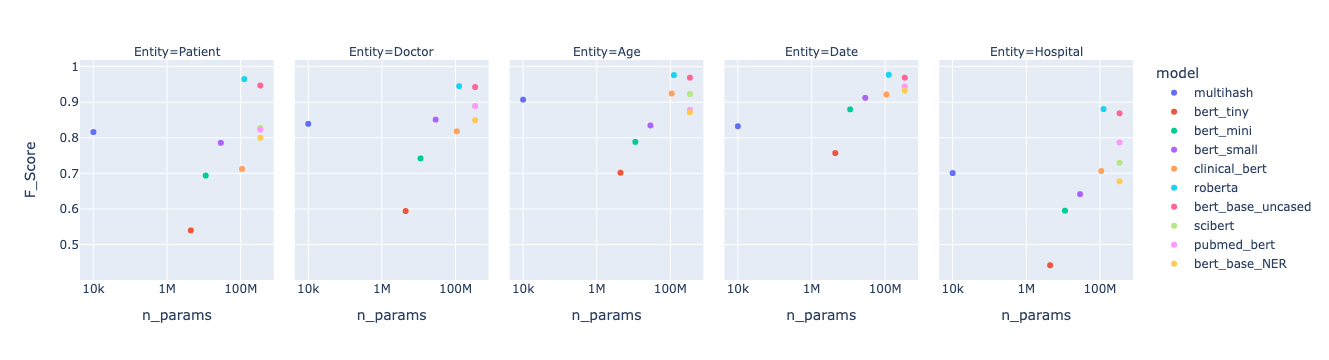

In [481]:
px.scatter(tmp.sort_values("n_params"), x="n_params", y="F_Score", facet_col="Entity", log_x=True, color="model")

In [345]:
px.scatter(df.loc[df.Entity == "Overall", x="TotalParameters", y="F_score", color="model", log_x=True, title="Performance Across Model Size")

SyntaxError: invalid syntax (<ipython-input-345-fc52095c5e6b>, line 1)

In [ ]:
px.histogram(df, x="model", y="F_score", color="model", log_x=True, title="Performance Across Model Size")